In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
import scipy.integrate as integrate
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import progressbar as pb
import os

C:\Users\loren\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Functions

Cross correlation:
The cross-correlation function measures how similar two signals are at different time lags. This can reveal patterns in how the particle's motion changes over time.
If the values are all very close to each other, which suggests that the particle's motion is similar at all considered time points. 
The absolut value is the magnitude of how much we can predict the value of the trajectory at a different time lag.

In [6]:
def corr(x,y,nmax,dt=False):
    '''fft, pad 0s, non partial'''

    assert len(x)==len(y)

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    yp=y-np.mean(y)

    # do fft and ifft
    cfx=np.fft.fft(xp,fsize)
    cfy=np.fft.fft(yp,fsize)
    if dt != False:
        freq = np.fft.fftfreq(n, d=dt)
        idx = np.where((freq<-1/(2*dt))+(freq>1/(2*dt)))[0]
        
        cfx[idx]=0
        cfy[idx]=0
        
    sf=cfx.conjugate()*cfy
    corr=np.fft.ifft(sf).real
    corr=corr/n

    return corr[:nmax]

# Simulation Class 

In [15]:
class OverdampedLangevinProcess(object):
    """
    This class will represent an overdamped Langevin process. The process is defined by the following SDE:
    F: A force function.
    D: A diffusion matrix or function.
    tlist: A list of time points.
    initial_position: The initial position of the particles.
    oversampling: The oversampling factor (default is 1).
    prerun: The number of prerun steps (default is 0).
    divD: The divergence of the diffusion matrix (default is None).
    D_is_constant: A flag indicating whether the diffusion matrix is constant (default is True).
    mode: The mode of the process (default is "drift").
    """
    
    def __init__(self, F, D, tlist, initial_position, oversampling = 1, prerun = 0, divD = None, D_is_constant = True, mode = "drift"):
        
        self.F = F
        self.Nparticles,self.d = initial_position.shape
        self.mode = 'mode'

        if hasattr(D,'shape'): # Check if D is a numpy array
            # Constant D.
            Dc = 1.*D 

            # Check if D has the right shape. If not, raise an error
            # if yes, it replicates the matrix for the number of particles
            if Dc.shape == (self.d,self.d):
                Dc = np.array([ Dc for i in range(self.Nparticles)])
            elif Dc.shape != (self.Nparticles,self.d,self.d):
                raise ValueError("Diffusion matrix shape is wrong:",Dc.shape," while dim is:",self.d)
            
            # Define the diffusion matrix and its square root
            self.__D__ = Dc
            self.D = lambda X : self.__D__
            self.__sqrt2D__ = np.array([ sqrtm(2 * self.__D__[i,:,:]) for i in range(self.Nparticles) ])
            self.sqrt2D = lambda X : self.__sqrt2D__
            self.mode = 'drift'
        
        # Handles the case where D is a function rather than a matrix
        else:
            self.D = D
            if self.d >= 2:
                def sqrt2D(X):
                    D = self.D(X)
                    return np.array([ np.real(sqrtm(2 * D[i,:,:])) for i in range(self.Nparticles) ])
            else:
                def sqrt2D(X):
                    return (2*self.D(X))**0.5
            self.sqrt2D = sqrt2D


            if self.mode == 'force':
                if divD is None:
                    epsilon = 1e-6
                    self.__dx__ = [[ np.array([[ 0 if (i,m)!= (ind,mu) else epsilon for m in range(self.d)] for i in range(self.Nparticles) ] )\
                                      for mu in range(self.d) ] for ind in range(self.Nparticles) ] 
                    def divD(x):
                        return np.einsum('jmimn->in',  np.array([[ (self.D(x+self.__dx__[ind][mu]) - self.D(x-self.__dx__[ind][mu]))/(2*epsilon) \
                                                                   for mu in range(self.d)] for ind in range(self.Nparticles) ]))
                    self.divD = divD

                else:
                    self.divD = divD 
                
        self.t = tlist

        self.Ntimesteps = len(self.t) 
        self.dt = self.t[1:] - self.t[:-1]
        
        self.simulate(initial_position,oversampling,prerun)
        self.compute_entropy_production()

    def dx(self,state,dt):
        """ The position increment in time dt."""

        # If the mode is 'force', the function returns the change in position calculated as the sum of:
        # - the deterministic part of the dynamics (F(state) * dt)
        # - the drift part of the dynamics (divD(state) * dt)
        # - the stochastic part of the dynamics (sqrt2D(state) * np.random.normal(size=(self.Nparticles,self.d)) * dt**0.5)
        # If the mode is not 'force', the function returns the change in position calculated as the sum of 
        # The deterministic part and the stochastic part, but without the divergence of the diffusion tensor.
        if self.mode == 'force': # x(t+dt) = x(t) + F(x(t))dt + divD(x(t))dt + sqrt(2D(x(t))) * N(0, sqrt(dt))
            return dt * self.F(state)  +  dt * self.divD(state)  +  np.einsum('imn,in->im',self.sqrt2D(state), np.random.normal(size=(self.Nparticles,self.d)) ) * dt**0.5
        
        else:
            #print(dt * self.F(state)  +  np.einsum('imn,in->im',self.sqrt2D(state), np.random.normal(size=(self.Nparticles,self.d)) ) * dt**0.5 )
            #print(self.sqrt2D(state))
            #print(np.random.normal(size=(self.Nparticles,self.d)))
            return dt * self.F(state)  +  np.einsum('imn,in->im',self.sqrt2D(state), np.random.normal(size=(self.Nparticles,self.d)) ) * dt**0.5 
        
    def simulate(self,initial_position,oversampling,prerun):
        
        """
        Simulates the motion of particles. 
        The method takes four arguments: 

        -self (which refers to the instance of the class)
    
        -initial_position (the initial positions of the particles)

        -oversampling (the number of intermediate steps to take in each time interval)

        -prerun (the number of initial steps to take before starting to record the positions).
        """

        state = 1. * initial_position
        # pre-equilibration:
        # it stabilizes the process permitting the particles to do  certain number of steps before
        # registrating the steps
        dt = self.dt[0] / oversampling # compute the time step
        for j in range( prerun*oversampling ): # updates the state by adding the change in position calculated by the dx method
            state += self.dx(state,dt)
        
        # Initialise timer:
        widgets = ['Simulating, stay tuned! Progress: ', pb.Percentage(), ' ', 
                           pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
        
        timer = pb.ProgressBar(widgets=widgets, maxval=len(self.dt)).start()
        
        
        # Start recording:
        # it simulates the process registrating for each time step the actual position and the force
        self.data = np.zeros((self.Ntimesteps,self.Nparticles,self.d))
        self.forces = np.zeros((self.Ntimesteps,self.Nparticles,self.d))
        for i,delta_t in timer(enumerate(self.dt)):
            self.data[i,:,:] = state
            self.forces[i,:,:] = self.F(state)
            dt = delta_t / oversampling
            for j in range( oversampling ):
                state += self.dx(state,dt)

        self.data[-1,:,:] = state
        self.forces[-1,:,:] = self.F(state)
        
        
        
    def compute_entropy_production(self):
        """Entropy production ("heat dissipated along the trajectory") and
        information. These are quantities per particle / per copy."""
        
        self.S = sum([ np.einsum('im,in,imn->', self.data[t+1,:,:]-self.data[t,:,:], self.F( 0.5*(self.data[t+1,:,:]+self.data[t,:,:]) ), np.linalg.inv(self.D(0.5*(self.data[t+1,:,:]+self.data[t,:,:])))) for t in range(self.Ntimesteps-1)])
        self.I = 0.25 * sum([ np.einsum('im,in,imn->', self.data[t+1,:,:]-self.data[t,:,:], self.F(self.data[t,:,:]), np.linalg.inv(self.D(self.data[t,:,:]))) for t in range(self.Ntimesteps-1)])/self.Nparticles

                       
    def plot_process_axes(self,a,beta,tmin=0,tmax=-1,particle_indices = None,cmap='viridis',**kwargs):
        for i in ( range(self.Nparticles) if particle_indices is None else particle_indices ):
            x,y = self.data[tmin:tmax,a,i],self.data[tmin:tmax,beta,i]
            plt.quiver(x[:-1],y[:-1],x[1:]-x[:-1],y[1:]-y[:-1],list(self.t[tmin:tmax-1]), cmap = cmap,headwidth = 1.0,headlength = 0.0, headaxislength=0., scale = 1.0,units = 'xy',lw=0.,**kwargs)
        plt.axis('equal') 
        plt.xticks([]) 
        plt.yticks([])
        
    def plotss(self):

        """
        Plot the position and force of the particles as a function of time and the two histograms
        """
        x= self.data[:,0,0]
        f= self.data[:,0,1]
        t=self.t
        fig, ax = plt.subplots(1, 4,figsize=(15,3))
        ax[0].plot(t,x)
        ax[1].hist(x,bins=50,density=True)
        ax[2].plot(t,f)
        ax[3].hist(f,bins=50,density=True)
        
        fig.tight_layout()
        
        plt.show()
        

These are the formulas used to compute the entropy production and the information
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$

$$
I = \frac{1}{4N_{\text{particles}}} \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \text{data}_{t} \right) \cdot D^{-1}\left( \text{data}_{t} \right)
$$

$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

# Simulation Class for SBI

In [8]:
class TorchOverdampedLangevinProcess_simulator(object):
    
    
    def __init__(self, F, D, tlist, initial_position, oversampling = 1, prerun = 0, divD = None, D_is_constant = True, mode = "drift"):
        self.F = F
        self.d = initial_position.shape[1]
        self.mode = 'mode'
      
        self.D = D
        self.t = tlist

        self.Ntimesteps = len(self.t) 
        self.dt = self.t[1:] - self.t[:-1]
        
        self.simulate(initial_position,oversampling,prerun)
        
    def dx(self,state,dt):
        return dt * self.F(state)  +  torch.matmul(torch.sqrt(2*self.D(state)), torch.normal(mean=torch.zeros(self.d) ) * dt**0.5 )

    def simulate(self,initial_position,oversampling,prerun):
        state = 1. * initial_position
        # pre-equilibration:
        dt = self.dt[0] / oversampling
        for j in range( prerun*oversampling ):
            state += self.dx(state,dt)

        # Start recording:
        self.data = np.zeros((self.Ntimesteps,1,self.d))
        self.forces = np.zeros((self.Ntimesteps,1,self.d))
        for i,delta_t in enumerate(self.dt):
            self.data[i,:,:] = state
            self.forces[i,:,:] = self.F(state)
            dt = delta_t / oversampling
            for j in range( oversampling ):
                state += self.dx(state,dt)

        self.data[-1,:,:] = state


In [19]:
def simulator_AOU_NL(pars,t_dict,k=1):
    """
    This is the official simulator used in the file later for the inference.
    These are the parameters of the model:
    dim=2
    μ = 1
    kBT = 1
    D1 = kBT*μ
    ϵ = pars[0]
    τ = pars[1]
    D2 = ϵ**2/τ
    """
    dim=2
    μ = 1
    kBT = 1
    D1 = kBT*μ
    ϵ = pars[0]
    τ = pars[1]
    D2 = ϵ**2/τ

    D = lambda X : torch.stack([ torch.tensor([[D1,0],[0,D2]]) for x in X ])

    # Force field parameters (stochastic Lorenz process)
    d = pars[2]
    
    force = lambda X : torch.stack([ torch.tensor([μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ]) for x in X ])
    
    # Simulation parameters
    initial_position = torch.tensor([[0 for i in range(dim)]]) 
    #dt = 0.01
    #oversampling = 5
    prerun = 100
    #Npts = 100000
    
    dt = t_dict['dt']
    oversampling = t_dict['oversampling']
    Npts = t_dict['Npts']
    
    tau = dt * Npts
    tlist = torch.linspace(0.,tau,Npts)
    
    # Run the simulation using our OverdampedLangevinProcess class
    np.random.seed(None)
    X = TorchOverdampedLangevinProcess_simulator(force,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun )
    
    # array of dimension (Npts, number of particles = 1, dimension=2)
    x = X.data[:,0,0]
    f_int = (X.forces[:,0,0]/μ+k*x)
    
    t = X.t.detach().numpy() 
    dt = t[1]-t[0]
    
    Cxx = corr(x,x,len(t),dt=dt)
    Cff = corr(f_int,f_int,len(t),dt=dt)
    Cfx = corr(f_int,x,len(t),dt=dt)
    
    #S1 = integrate.cumtrapz(Cff, x=t, axis=-1, initial=0)
    #S1 = 2*μ*integrate.cumtrapz(S1, x=t, axis=-1, initial=0)
    
    S2 = integrate.cumtrapz(Cfx - Cfx[0], x=t, axis=-1, initial=0)
    
    S3 = integrate.cumtrapz(Cfx, x=t, axis=-1, initial=0)
    S3 = -μ*k*integrate.cumtrapz(S3, x=t, axis=-1, initial=0)
    
    t_corr = 10
    
    idx_corr = np.where((t>0)*(t<t_corr))[0]
    
    #S_red = 1+(S1[idx_corr]+S2[idx_corr]+S3[idx_corr])/(kBT*t[idx_corr])
    S_red = 1-(S2[idx_corr]+S3[idx_corr])/(kBT*t[idx_corr]) # the energy production is to to the fluctuation-dissipation theorem

    return np.concatenate((Cxx[idx_corr],S_red)) # return the correlation function and the reduced entropy production

# Inference 

## Potential visualisation

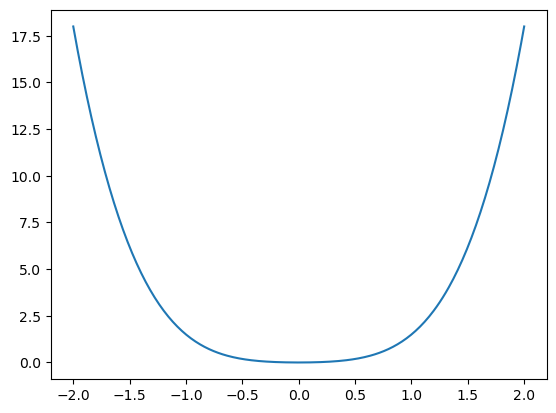

In [16]:
def dw(x,k,d):
    return k*x**2/2+d*x**4/4

x_pot = np.linspace(-2,2,300)

dw1 = dw(x_pot,1,4)
plt.plot(x_pot,dw1)

## Observation function

In [17]:
def observation(X,μ=1,k=1,t_corr=10):
    
    x = X.data[:,0,0]
    t = X.t 
    dt = t[1]-t[0]
    
    Cxx = corr(x,x,len(t),dt=dt)
    
    S1 = integrate.cumtrapz(Cxx, x=t, axis=-1, initial=0)
    S1 = integrate.cumtrapz(S1, x=t, axis=-1, initial=0)
    
    idx_corr = np.where((t>0)*(t<t_corr))[0]
    
    S_red = ((Cxx[0]-Cxx[idx_corr])+((μ*k)**2)*S1[idx_corr])/(kBT*μ*t[idx_corr])
    
    return np.concatenate((Cxx[idx_corr],S_red))

## Examples
Here are provided some examples of the use of the class, mainly the differences are that 2 types of forces are used and also all the other classical parameters of the Langevin equation, generally are all between $10^-2$ and $10$

In [18]:
dt = 0.01
oversampling = 4
prerun = 100
Npts = 50000

t_dict = {}

t_dict['dt'] = dt
t_dict['oversampling'] = oversampling
t_dict['Npts'] = Npts

### Simulation

In [12]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 1
τ = 1
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,0
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(None)
X_0 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:39


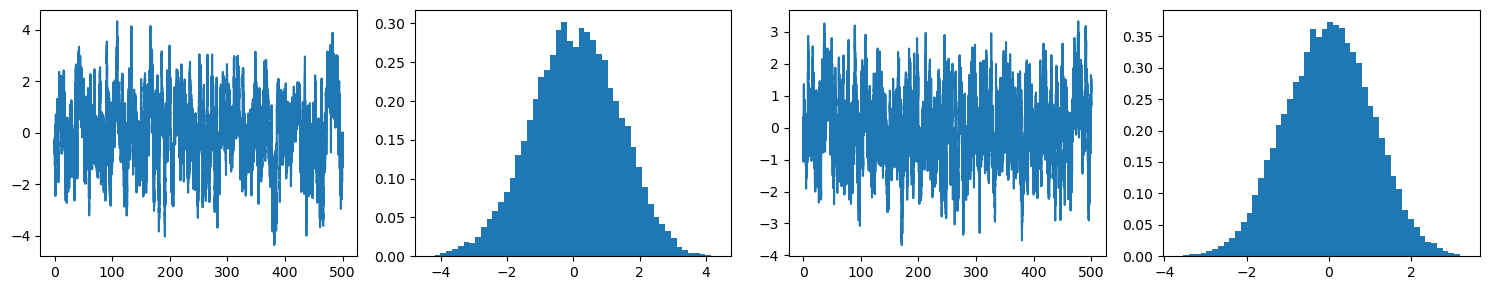

In [13]:
X_0.plotss()

In [21]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 1
τ = 3
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,2
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_1 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:40


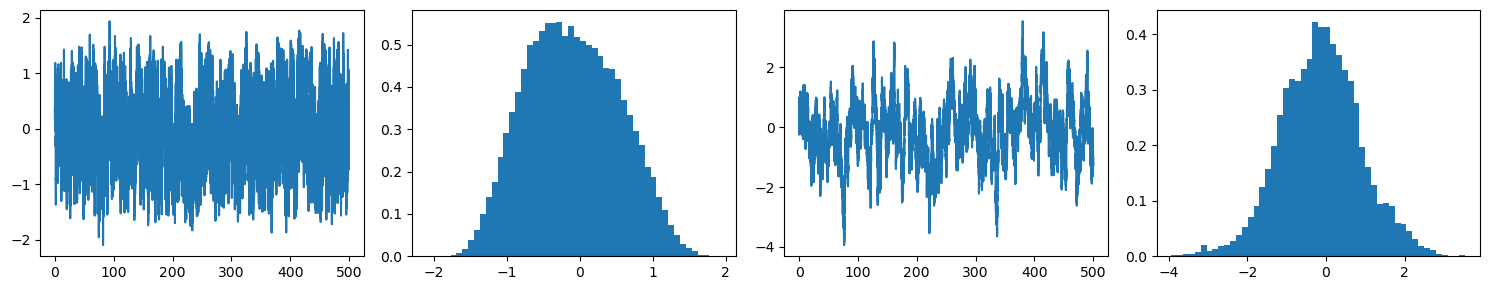

In [67]:
X_1.plotss()

In [22]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 2
τ = 2
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,4
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_2 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:45


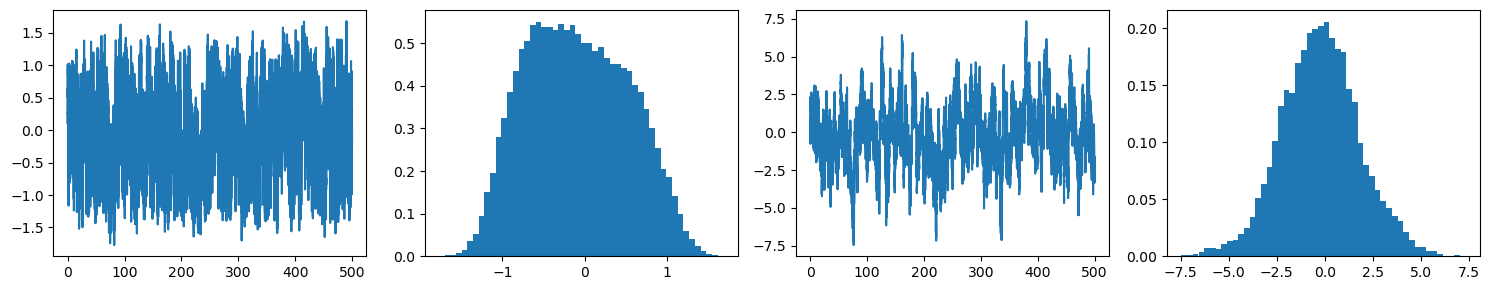

In [69]:
X_2.plotss()

In [70]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 0.3
τ = 1
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,1
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_3 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:20


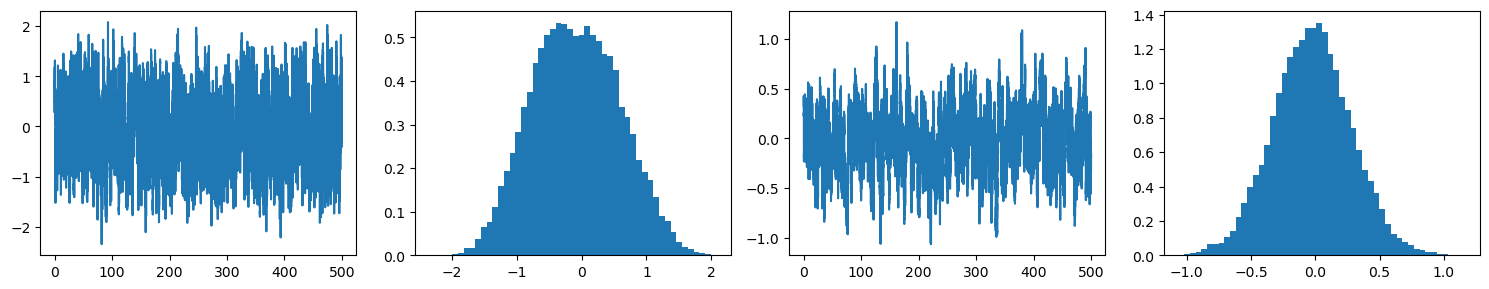

In [71]:
X_3.plotss()

In [72]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 0.01
τ = 2
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,2
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(None)
X_4 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:20


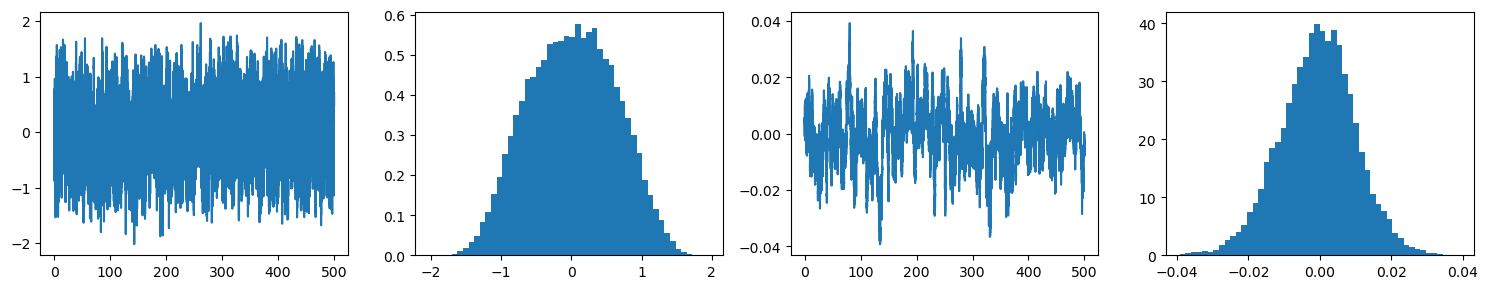

In [73]:
X_4.plotss()

In [74]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 0.02
τ = 1
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,2
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(None)
X_5 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:20


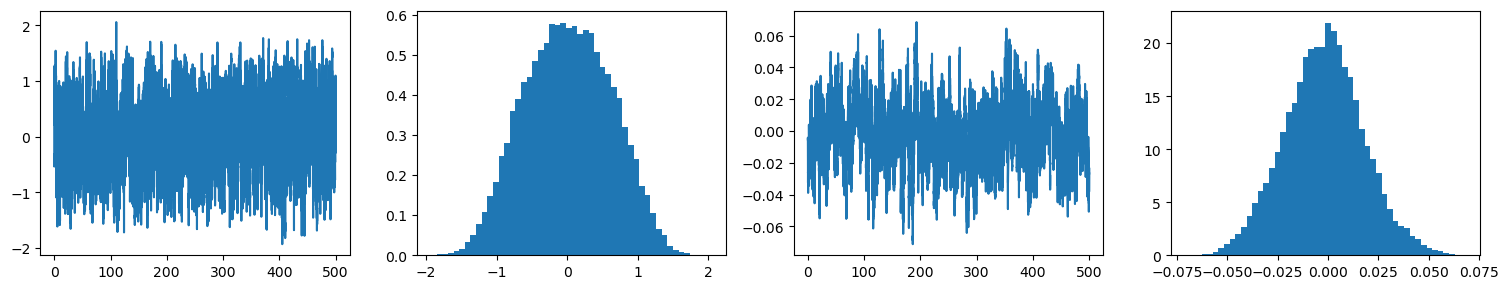

In [75]:
X_5.plotss()

In [76]:
dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = 0.025
τ = 0.8
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']
tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,2
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(None)
X_6 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

Simulating, stay tuned! Progress: 100% |||||||||||||||||||||||||| Time: 0:00:20


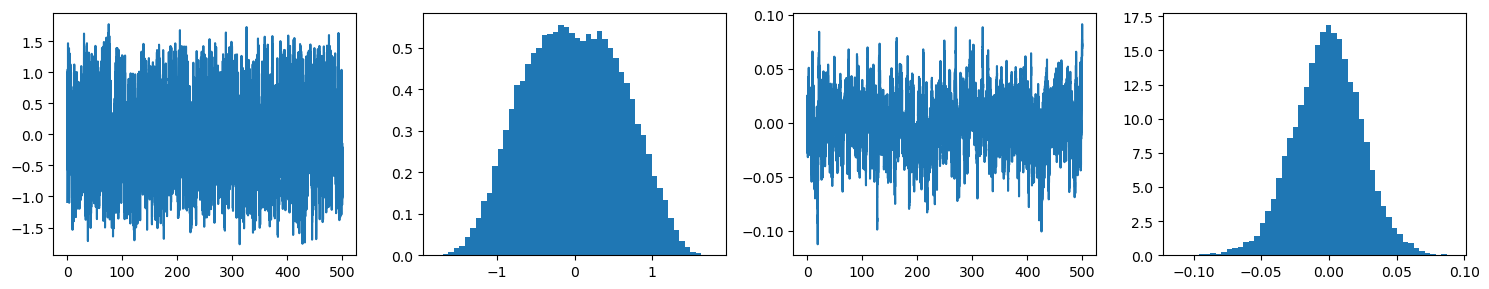

In [77]:
X_6.plotss()

In [78]:
X_6.S/500

-0.003991551739284424

### Inference

This part simulates the part of the Langevin process.
The output are the reduced entropy and the autocorellation xx, xf and ff.

In [79]:
low2 = np.array([0,0,0])
high2 = np.array([3,4,8])

prior_AOU_NL_ex = utils.BoxUniform(low=low2, high=high2) # prior distribution, a uniform box in a 3D space given by low2 and high2

def simulator_AOU_NL_ex(pars):
    return simulator_AOU_NL(pars,t_dict,k=1)

Remember that the simulator returns the correlation function xx and the reduced entropy production. I am not sure about what it does the infer. These values? Or what?
There is also the possibility to work with n_workers in the infer function (it uses more cores, i don't know how it work)

In [ ]:
posterior_AOU_NL_ex = infer(simulator_AOU_NL_ex, prior_AOU_NL_ex, method="SNPE", num_simulations=10000)#SNLE

2024-04-11 19:47:07.396997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 19:47:07.526057: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 19:47:09.395744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/pgi/linux86-64/18.7/libso
2024-04-11 19:47:09.396198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
#posterior_AOU_NL_ex_2 = infer(simulator_AOU_NL_ex, prior_AOU_NL_ex, method="SNPE", num_simulations=6000)#SNLE

### Fittt

This takes the observed data from the observation process defined above that condition the posterior distribution (fit the observed data).
The call posterior.sample(x), you're asking for samples from the distribution P(θ|x). That is, you're generating possible values of θ that are consistent with the observed data x

We fit the data obtained from our simulator on all the correllations done in the example part with different parameters. 

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

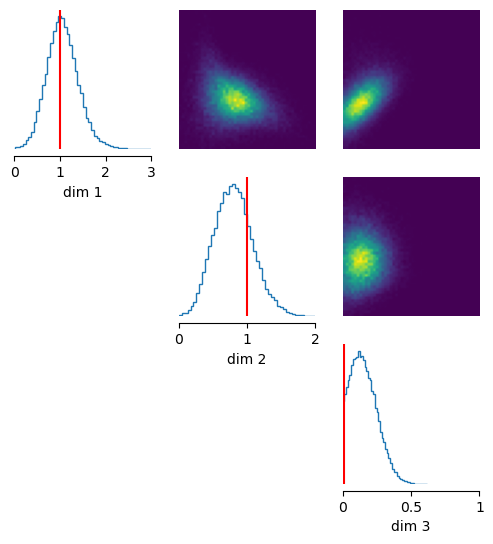

In [163]:
observation_AOU_nl_EX = observation(X_0,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[low2[0], high2[0]], [0, 2], [0, 1]], figsize=(6, 6))
ax[0,0].axvline(1,color='red')
ax[1,1].axvline(1,color='red')
ax[2,2].axvline(0.01,color='red')

params_0 = []
for i in range(3):
    params_0.append(torch.mean(samples_AOU_nl_EX[:,i]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

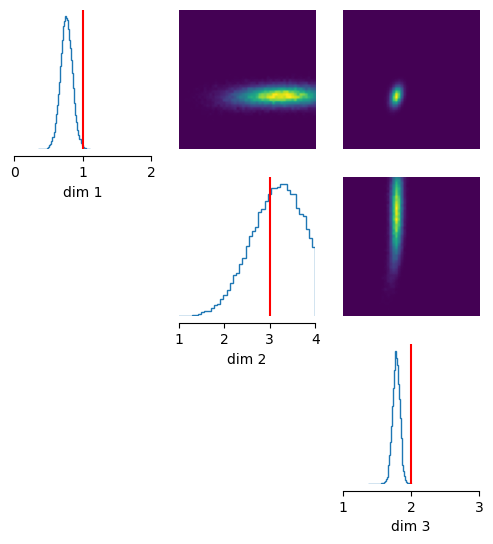

In [372]:
observation_AOU_nl_EX = observation(X_1,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[0, 2], [1, 4], [1, 3]], figsize=(6, 6))
ax[0,0].axvline(1,color='red')
ax[1,1].axvline(3,color='red')
ax[2,2].axvline(2,color='red')

params_1 = []
for i in range(3):
    params_1.append(torch.mean(samples_AOU_nl_EX[:,i]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

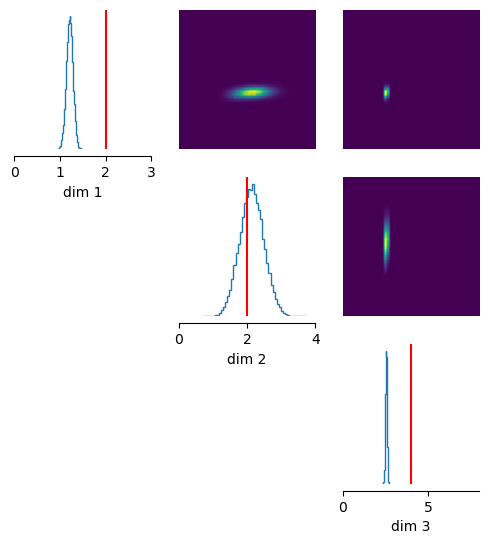

In [129]:
observation_AOU_nl_EX = observation(X2_2,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[low2[0], high2[0]], [low2[1], high2[1]], [low2[2], high2[2]]], figsize=(6, 6))
ax[0,0].axvline(2,color='red')
ax[1,1].axvline(2,color='red')
ax[2,2].axvline(4,color='red')

params_2 = []
for i in range(3):
    params_2.append(torch.mean(samples_AOU_nl_EX[:,i]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

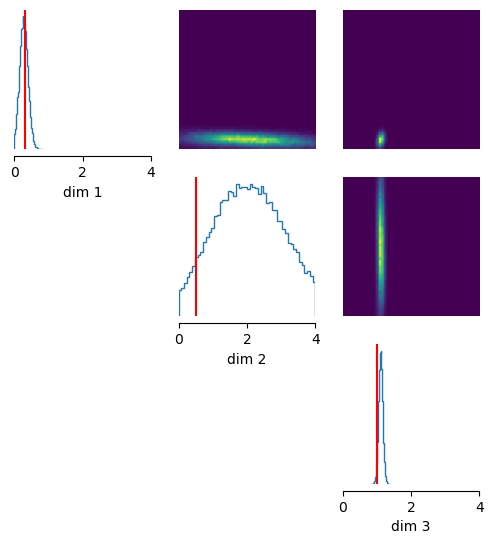

In [200]:
observation_AOU_nl_EX = observation(X2_3,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[0, 4], [low2[1], high2[1]], [0, 4]], figsize=(6, 6))
ax[0,0].axvline(0.3,color='red')
ax[1,1].axvline(0.5,color='red')
ax[2,2].axvline(1,color='red')

params_3 = []
for i in range(3):
    params_3.append(torch.mean(samples_AOU_nl_EX[:,i]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

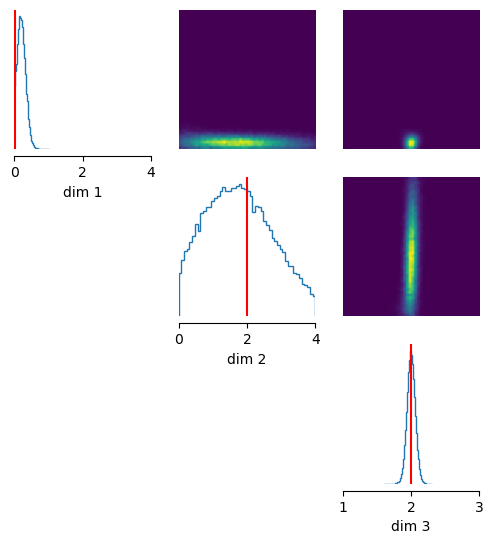

In [282]:
observation_AOU_nl_EX = observation(X2_4,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[0, 4], [low2[1], high2[1]], [1, 3]], figsize=(6, 6))
ax[0,0].axvline(0.01,color='red')
ax[1,1].axvline(2,color='red')
ax[2,2].axvline(2,color='red')

params_4 = []
for i in range(3):
    params_4.append(torch.mean(samples_AOU_nl_EX[:,i]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

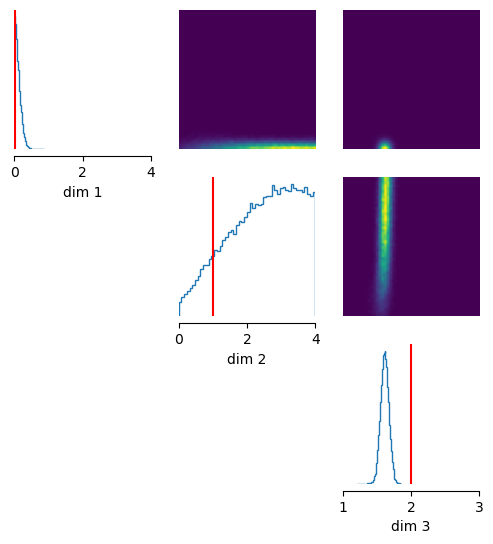

In [283]:
observation_AOU_nl_EX = observation(X2_5,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[0, 4], [low2[1], high2[1]], [1, 3]], figsize=(6, 6))
ax[0,0].axvline(0.02,color='red')
ax[1,1].axvline(1,color='red')
ax[2,2].axvline(2,color='red')

params_5 = []
for i in range(3):
    params_5.append(torch.mean(samples_AOU_nl_EX[:,i]))

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

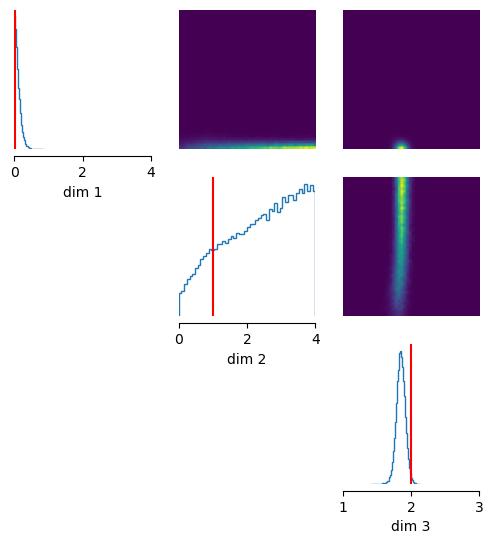

In [325]:
observation_AOU_nl_EX = observation(X2_6,μ=1,k=1)

samples_AOU_nl_EX = posterior_AOU_nl_EX.sample((50000,), x=observation_AOU_nl_EX)
log_probability_AOU_nl_EX = posterior_AOU_nl_EX.log_prob(samples_AOU_nl_EX, x=observation_AOU_nl_EX)
fig,ax = analysis.pairplot(samples_AOU_nl_EX, limits=[[0, 4], [low2[1], high2[1]], [1, 3]], figsize=(6, 6))
ax[0,0].axvline(0.025,color='red')
ax[1,1].axvline(1,color='red')
ax[2,2].axvline(2,color='red')

params_6 = []
for i in range(3):
    params_6.append(torch.mean(samples_AOU_nl_EX[:,i]))

## Confronting EP

In [20]:
params_0[0].numpy()

NameError: name 'params_0' is not defined

In [ ]:
pars = params_0

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_0_sig = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
pars = params_1

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_1_sig = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
pars = params_2

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_2_sig = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
pars = params_3

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_3_sig = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
pars = params_4

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_4_sig_2 = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
pars = params_5

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_5_sig = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
pars = params_6

dim=2
μ = 1
kBT = 1
D1 = kBT*μ
ϵ = pars[0].numpy()
τ = pars[1].numpy()
D2 = ϵ**2/τ

#σ = μ*ϵ**2/(1+k*μ*τ)
#σ

D = lambda X : np.array([ np.array([[D1,0],[0,D2]]) for x in X ])

# Simulation parameters
initial_position = np.array([[0 for i in range(dim)]]) 
dt = t_dict['dt']
oversampling = t_dict['oversampling']
prerun = 100
Npts = t_dict['Npts']

tau = dt * Npts
tlist = np.linspace(0.,tau,Npts)

# Force field parameters (stochastic Lorenz process)
k, d = 1,pars[2].numpy()
force2 = lambda X : np.array([ [μ*(-(k*x[0]+d*x[0]**3)+x[1]),-x[1]/τ] for x in X ])

# Run the simulation using our OverdampedLangevinProcess class
np.random.seed(4)
X_6_sig = OverdampedLangevinProcess(force2,D,tlist,initial_position=initial_position,oversampling=oversampling,prerun=prerun)

In [ ]:
X_5_sig.S/500

In [ ]:
σ0_th = X_0.S/500
σ0_est = X_0_sig.S/500

σ1_th = X_1.S/500
σ1_est = X_1_sig.S/500

σ2_th = X_2.S/500
σ2_est = X_2_sig.S/500

σ3_th = X_3.S/500
σ3_est = X_3_sig.S/500

σ4_th = X_4.S/500
σ4_est = X_4_sig.S/500

σ5_th = X_5.S/500
σ5_est = X_5_sig.S/500

σ6_th = X_6.S/500
σ6_est = X_6_sig.S/500

In [ ]:
σ_th = [σ0_th,σ1_th,σ2_th,σ3_th,σ4_th,σ5_th,σ6_th]
σ_est = [σ0_est,σ1_est,σ2_est,σ3_est,σ4_est,σ5_est,σ6_th]

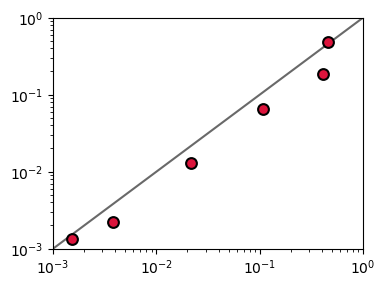

In [333]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

s=60

ax.scatter(σ_th,σ_est,s=s,edgecolor='black',lw=1.5,facecolor='crimson',zorder=2)
xx = np.linspace(0,100,200)
ax.plot(xx,xx,zorder=0,color='dimgray')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e-3,1e0])
ax.set_ylim([1e-3,1e0])

plt.show()


In [ ]:
print(X_0.S/500,'  ',X_0_sig.S/500)

In [ ]:
print(X_1.S/500,'  ',X_1_sig.S/500)

In [ ]:
print(X_2.S/500,'  ',X_2_sig.S/500)

In [ ]:
print(X_3.S/500,'  ',X_3_sig.S/500)

In [ ]:
print(X_4.S/500,'  ',X_4_sig.S/500)

In [ ]:
print(X_5.S/500,'  ',X_5_sig.S/500)